In [6]:
import csv
import pickle
import datetime
import pandas as pd
import altair as alt
import numpy as np
from vega_datasets import data

In [7]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Extracting data from the transactions file

In [44]:
transactions = list()
purchases = list()
transfers = list()
topups = list()
data = dict()
users = dict()

i = 0
with open("data/transactions.csv", newline='') as csvfile:
    transreader = csv.reader(csvfile, delimiter = ' ', quotechar = '|')
    for row in transreader:
        transactions.append(row[0].split(','))
        if transactions[i][3] not in users.keys():
            users[transactions[i][3]] = 1
        else:
            users[transactions[i][3]] += 1
        if transactions[i][2] == 'PURCHASE':
            purchases.append(row[0].split(','))
            if transactions[i][5] not in data.keys():
                data[transactions[i][5]] = 1
            else:
                data[transactions[i][5]] += 1
        elif transactions[i][2] == 'USERTRANSFER':
            transfers.append(row[0].split(','))
        else:
            topups.append(row[0].split(','))
        i += 1

In [49]:
frame = pd.DataFrame({'cost in indonesian rupiah': list(data.keys()),
                     'transactions': list(data.values())})
frame2 = pd.DataFrame({'user': list(users.keys()),
                      'transactions': list(users.values())})

## Graph of each user's number of transactions.
##### I'm not entirely sure how this data could be useful yet, since it's separated by user.

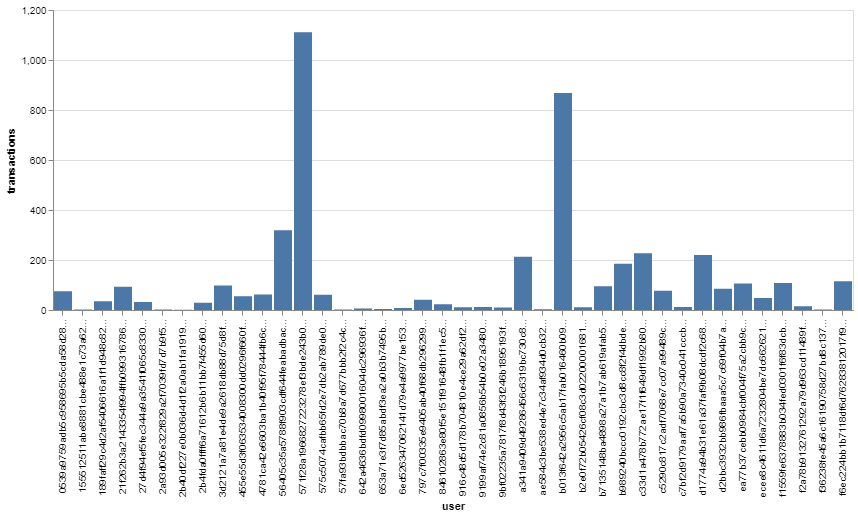

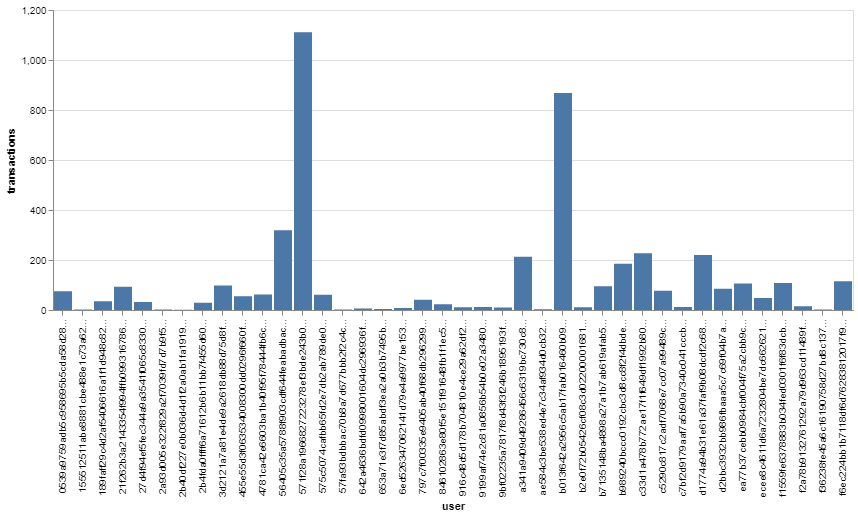

In [22]:
alt.Chart(frame2).mark_bar().encode(
    x='user',
    y='transactions'
)

## From the transactions data, a graph of the number of transactions of different costs.

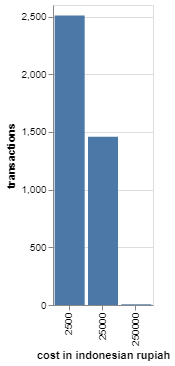

In [50]:
alt.Chart(frame).mark_bar(size=30).encode(
    x='cost in indonesian rupiah',
    y='transactions',
    tooltip=['cost in indonesian rupiah:Q', 'transactions:Q']
).properties(width=100)

## Purchases vs. Transfers vs. Topups

In [52]:
categorized_transactions = dict()

categorized_transactions['purchases'] = 0
categorized_transactions['transfers'] = 0
categorized_transactions['topups'] = 0

for purchase in purchases:
    categorized_transactions['purchases'] += int(purchase[4])

for transfer in transfers:
    categorized_transactions['transfers'] += int(transfer[5])

for topup in topups:
    categorized_transactions['topups'] += int(topup[4])
    

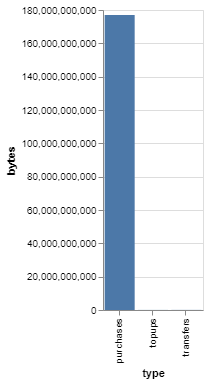

In [53]:
categorized_transactions_df = pd.DataFrame({'type': list(categorized_transactions.keys()),
                                           'bytes': list(categorized_transactions.values())})

alt.Chart(categorized_transactions_df).mark_bar(size=30).encode(
    x='type',
    y='bytes',
    tooltip=['type:N', 'bytes:Q']
).properties(width=100)

## Graph of how much data was bought per day, in total, by the members of the Bokondini community.

In [21]:
bytes = dict()

for entry in purchases:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[4]) / 1000000000
    else:
        bytes[entry[0]] += float(entry[4]) / 1000000000

In [22]:
dates = list()
for i in range((datetime.date(2019, 5, 17) - datetime.date(2019, 3, 4)).days + 1):
    dates.append(str(datetime.date(2019, 3, 4) + datetime.timedelta(days=i)))
def load_average(week):
    with open("data/weeks/remote_userlogs/remote_userlog-%s.pickle" % week, mode="rb") as h:
        remote_userlog = pickle.load(h)
    times = dict()
    days = list()
    index = 0
    days.append(remote_userlog[index]['start_time'].date())
    for entry in remote_userlog:
        if entry['start_time'].date() != days[index]:
            index += 1
            days.append(entry['start_time'].date())
        for day in days:
            times[str(day)] = 0
    for entry in remote_userlog:
        times[str(entry['start_time'].date())] += entry['bytes_b_to_a']
        times[str(entry['start_time'].date())] += entry['bytes_a_to_b']
    return times

In [27]:
total = list()
dates = list()
date = datetime.date(2019, 3, 4)
while (date < datetime.date(2019, 5, 17)):
    print(date)
    total.append(load_average(str(date)))
    date += datetime.timedelta(days=7)

2019-03-04
2019-03-11
2019-03-18
2019-03-25
2019-04-01
2019-04-08
2019-04-15
2019-04-22
2019-04-29
2019-05-06
2019-05-13


In [28]:
days = dict()

for week in total:
    for day in week:
        if day not in days.keys():
            days[day] = week[day] / 1000000000
        else:
            days[day] += week[day] / 1000000000
            
total = list()
for entry in bytes:
    total.append(['purchase', entry, bytes[entry]])
    
for entry in days:
    total.append(['use', entry, days[entry]])

2019-03-04
{'2019-03-04': 1678956031, '2019-03-05': 3542029468, '2019-03-06': 2230148970, '2019-03-07': 3695468772, '2019-03-08': 3721051427, '2019-03-09': 5186276456, '2019-03-10': 5916655202}
2019-03-05
{'2019-03-04': 1678956031, '2019-03-05': 3542029468, '2019-03-06': 2230148970, '2019-03-07': 3695468772, '2019-03-08': 3721051427, '2019-03-09': 5186276456, '2019-03-10': 5916655202}
2019-03-06
{'2019-03-04': 1678956031, '2019-03-05': 3542029468, '2019-03-06': 2230148970, '2019-03-07': 3695468772, '2019-03-08': 3721051427, '2019-03-09': 5186276456, '2019-03-10': 5916655202}
2019-03-07
{'2019-03-04': 1678956031, '2019-03-05': 3542029468, '2019-03-06': 2230148970, '2019-03-07': 3695468772, '2019-03-08': 3721051427, '2019-03-09': 5186276456, '2019-03-10': 5916655202}
2019-03-08
{'2019-03-04': 1678956031, '2019-03-05': 3542029468, '2019-03-06': 2230148970, '2019-03-07': 3695468772, '2019-03-08': 3721051427, '2019-03-09': 5186276456, '2019-03-10': 5916655202}
2019-03-09
{'2019-03-04': 1678

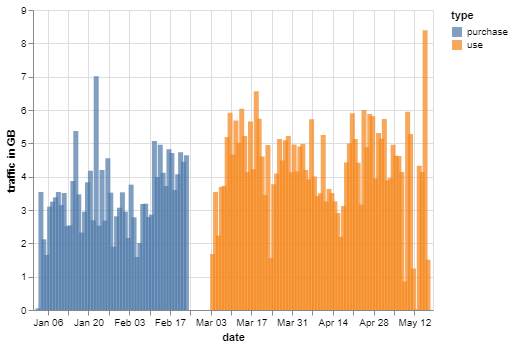

In [58]:
day_avg_df = pd.DataFrame(total)

alt.Chart(day_avg_df).mark_bar(opacity=0.7).encode(
    x=alt.X('1:T', title='date'),
    y=alt.Y('2:Q', stack=None, title='traffic in GB'),
    color=alt.Color('0:N', title='type')
)

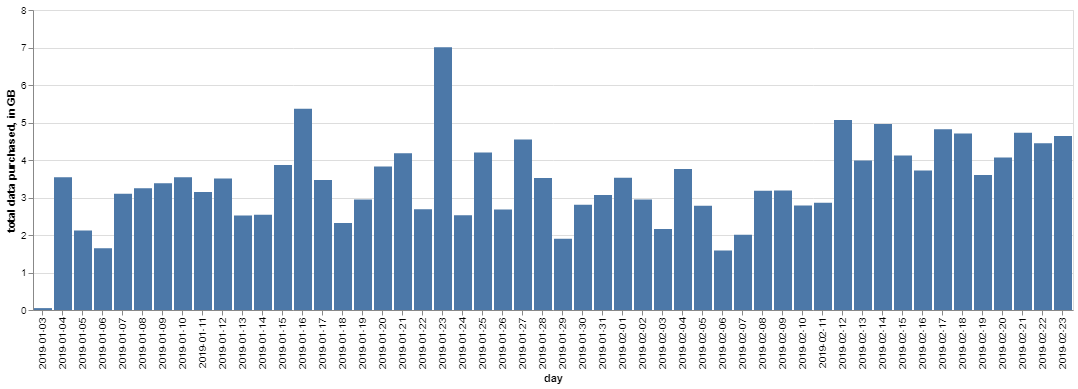

In [56]:
bytes = dict()

for entry in purchases:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[4]) / 1000000000
    else:
        bytes[entry[0]] += float(entry[4]) / 1000000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data purchased, in GB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data purchased, in GB'
)

## Graph of how much data was transferred between users per day, in total, by the members of the Bokondini community

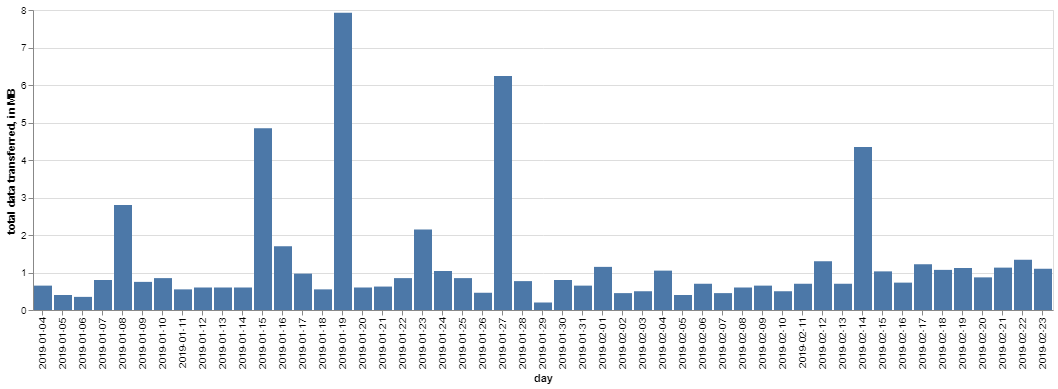

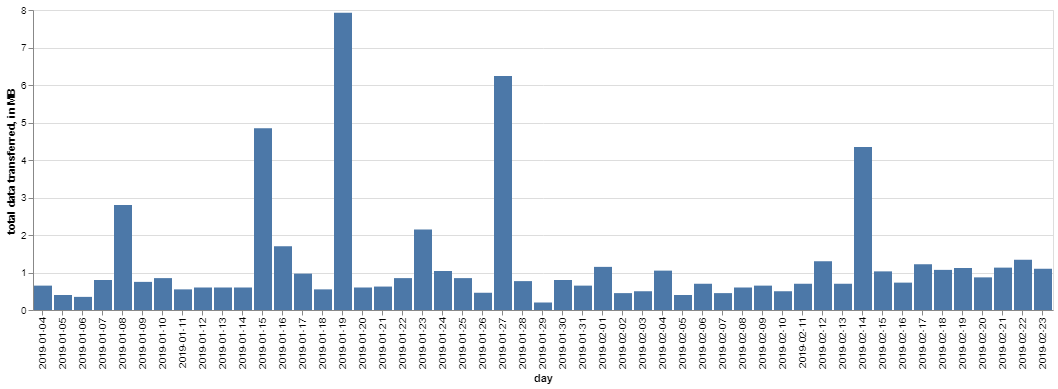

In [25]:
bytes = dict()

for entry in transfers:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[5].strip()) / 1000000
    else:
        bytes[entry[0]] += float(entry[5].strip()) / 1000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data transferred, in MB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data transferred, in MB'
)

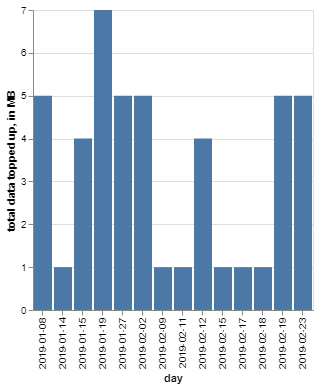

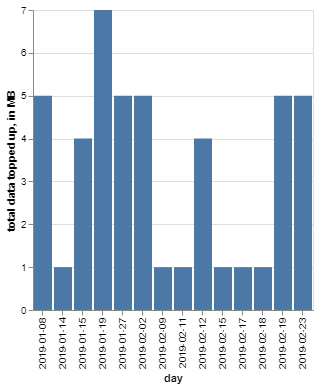

In [26]:
bytes = dict()

for entry in topups:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[4]) / 1000000
    else:
        bytes[entry[0]] += float(entry[4]) / 1000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data topped up, in MB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data topped up, in MB'
)